 # Petfinder: Bay Area Dog Adoption
 ![Icon](images/pets.jpg)

### Notebook Contents

-------

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from transformers import pipeline
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [2]:
dogs = pd.read_csv('./petfinder_data/cleandogs.csv')

In [76]:
pd.set_option('display.max_columns', 500)

In [3]:
# Creating a list of my categorical columns for later use in modeling
categorical = ['id', 'organization_id', 'name', 'description', 'photos', 'status_changed_at', 'published_at', 'zipcode', 'days_on_petfinder']

In [4]:
# Creating a df of numerical columns for later use in modeling
numerical = dogs.drop(categorical, axis=1)

In [5]:
# Dropping columns from data frame and dummifying categorical columns
X = dogs.drop(columns=categorical)
y = dogs['days_on_petfinder']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.30,
    stratify=y,
    random_state=42)

In [7]:
# Baseline
y.value_counts(normalize=True)

1.0    0.529394
0.0    0.470606
Name: days_on_petfinder, dtype: float64

## Modeling

In [8]:
# Function to display model metrics
def score_disp(X_train, X_test, y_train, y_test, gs):
    best_score = gs.best_score_
    train_score = gs.score(X_train, y_train)
    test_score = gs.score(X_test, y_test)

    print(f'best score: {best_score}')
    print(f'train score: {train_score}')
    print(f'test score: {test_score}')
    print(f'best params: \n{gs.best_params_}')

In [11]:
%%time
# Fitting classification models
lr = LogisticRegression(max_iter=5000)
lr.fit(X_train, y_train)
lr_train = lr.score(X_train, y_train)
lr_test = lr.score(X_test, y_test)

bag = BaggingClassifier()
bag.fit(X_train, y_train)
bag_train = bag.score(X_train, y_train)
bag_test = bag.score(X_test, y_test)

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_train = rf.score(X_train, y_train)
rf_test = rf.score(X_test, y_test)

ada = AdaBoostClassifier()
ada.fit(X_train, y_train)
ada_train = ada.score(X_train, y_train)
ada_test = ada.score(X_test, y_test)

xgb = XGBClassifier()
xgb.fit(X_train, y_train)
xgb_train = xgb.score(X_train, y_train)
xgb_test = xgb.score(X_test, y_test)

CPU times: user 1min 43s, sys: 1.03 s, total: 1min 44s
Wall time: 22.9 s


In [12]:
# Creating data frame for visualization of results
model = ['Logistic Regression', 'Bagging', 'Random Forest', 'AdaBoost', 'XGBoost']
train = [lr_train, bag_train, rf_train, ada_train, xgb_train]
test = [lr_test, bag_test, rf_test, ada_test, xgb_test]
results = pd.DataFrame({'model': model, 'train_score': train, 'test_score': test})
results

,model,train_score,test_score
0,Logistic Regression,0.697225,0.685856
1,Bagging,0.974592,0.710625
2,Random Forest,0.993264,0.728732
3,AdaBoost,0.683093,0.679194
4,XGBoost,0.814893,0.729245


#### Misclassified Listings

In [15]:
# Get predictions
preds = lr.predict(X_test)

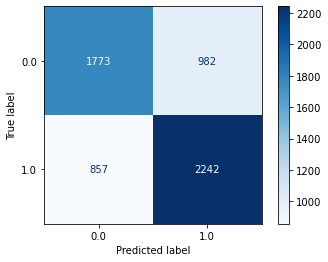

In [28]:
# Confusion matrix

plot_confusion_matrix(lr, X_test, y_test, cmap='Blues', values_format='d');

In [29]:
df_classified = pd.DataFrame(data=y_test)
df_classified = df_classified.rename({'days_on_petfinder' : 'actual'}, axis=1)
df_classified['predicted'] = preds
df_classified['misclassified'] = df_classified['actual'] - df_classified['predicted']
df_classified['actual'] = df_classified['actual'].map({1 : 'Speedy_adoption', 0 : 'Slow_adoption'})
df_classified['predicted'] = df_classified['predicted'].map({1 : 'Speedy_adoption', 0 : 'Slow_adoption'})
df_classified['misclassified'] = df_classified['misclassified'].map({1:'Yes', 0:'No', -1:'Yes'})
df_classified = df_classified[df_classified['misclassified'] != 0]

In [30]:
# Sorting so that I only have posts that are misclassified 

misclass_listings = df_classified[df_classified['misclassified'] == 'Yes']

In [31]:
misclass_listings.head()

,actual,predicted,misclassified
7162,Slow_adoption,Speedy_adoption,Yes
10195,Speedy_adoption,Slow_adoption,Yes
3377,Slow_adoption,Speedy_adoption,Yes
14147,Slow_adoption,Speedy_adoption,Yes
2674,Speedy_adoption,Slow_adoption,Yes


In [32]:
misclass_listings['actual'].value_counts()

Slow_adoption      982
Speedy_adoption    857
Name: actual, dtype: int64

In [41]:
result = pd.merge(misclass_listings, dogs, left_index=True, right_index=True)

In [42]:
result.head()

,actual,predicted,misclassified,id,organization_id,name,description,photos,videos,status_changed_at,...,city_Windsor,city_Winters,city_Woodland,city_Yuba City,city_los altos,city_napa,city_woodland,days_on_petfinder,polarity,desc_len
7162,Slow_adoption,Speedy_adoption,Yes,46068036,CA781,Davey,"Davey is a very well socialized puppy, happy a...",[{'small': 'https://dl5zpyw5k3jeb.cloudfront.n...,0,2019-12-30 21:45:36+00:00,...,0,0,0,0,0,0,0,0.0,0.9078,107
10195,Speedy_adoption,Slow_adoption,Yes,47143890,CA86,Toby,Sweet and handsome Toby is waiting to be your ...,[{'small': 'https://dl5zpyw5k3jeb.cloudfront.n...,0,2020-01-28 02:03:00+00:00,...,0,0,0,0,0,0,0,1.0,0.8964,97
3377,Slow_adoption,Speedy_adoption,Yes,44538568,CA1298,Renwah,"Renwah is 7 weeks old, weighs 3 pounds at the ...",[{'small': 'https://dl5zpyw5k3jeb.cloudfront.n...,0,2019-05-30 18:57:16+00:00,...,0,0,0,0,0,0,0,0.0,0.4588,93
14147,Slow_adoption,Speedy_adoption,Yes,48452689,CA522,Kronk,Looking for a loyal and friendly companion? Kr...,[{'small': 'https://dl5zpyw5k3jeb.cloudfront.n...,0,2020-08-05 03:35:10+00:00,...,0,0,0,0,0,0,0,0.0,0.8986,105
2674,Speedy_adoption,Slow_adoption,Yes,44345962,CA1727,Kessie,Many of our newly listed puppies are scheduled...,[{'small': 'https://dl5zpyw5k3jeb.cloudfront.n...,0,2019-04-02 03:02:39+00:00,...,0,0,0,0,0,0,0,1.0,0.0000,123


In [52]:
good = result[result['predicted'] == 'Slow_adoption']

In [53]:
bad = result[result['predicted'] == 'Speedy_adoption']

In [54]:
good.organization_id.value_counts()   #positive misclass

CA1727    62
CA86      52
CA2490    50
CA2452    44
CA2324    36
          ..
CA1003     1
CA1644     1
CA1725     1
CA2340     1
CA874      1
Name: organization_id, Length: 120, dtype: int64

In [68]:
bad.organization_id.value_counts()   #bad misclass

CA1973    105
CA2285     64
CA162      59
CA1005     52
CA2436     42
         ... 
CA1938      1
CA2326      1
CA339       1
WA526       1
CA874       1
Name: organization_id, Length: 121, dtype: int64

In [45]:
dogs.organization_id.value_counts()   #total

CA1973    909
CA2285    861
CA162     804
CA1726    716
CA2324    623
         ... 
CA2488      1
TX1224      1
CA2714      1
CA2788      1
CA130       1
Name: organization_id, Length: 230, dtype: int64

CA1727: Almost 7% of the dogs at this rescue were adopted faster than predicted over a two year period. (62/583) \
CA86: 12.2 % of the dogs at this rescue were adopted faster than predicted over a two year period. (52/425) \
CA2490: 8.2% of the dogs at this rescue were adopted faster than predicted over a two year period. (50/612) \
CA2452: 8.5% of the dogs at this rescue were adopted faster than predicted over a two year period.  (44/516) \

CA1973: 11.6% of the dogs at this rescue were adopted slower than predicted. (105/909) - foster based rescue with no shelter/facility- sf and san ramon \
CA2285: 7.4% of the dogs at this rescue were adopted slower than predicted. (64/861) \
CA162: 7.3% of the dogs at this rescue were adopted slower than predicted. (59/804) \
CA1005: 8.4% of the dogs at this rescue were adopted slower than predicted. (52/617) - put email first, shorter descriptions. Dublin, CA \
CA2436: 10.5% of the dogs at this rescue were adopted slower than predicted. (42/400) - Santa Rosa, CA

In [79]:
eh = dogs[dogs['organization_id'] == 'CA1005']
eh.head(20)

,id,organization_id,name,description,photos,videos,status_changed_at,published_at,distance,breeds.mixed,fixed,house_trained,special_needs,shots_current,good_with_kids,good_with_dogs,good_with_cats,zipcode,has_photo,color_Apricot / Beige,color_Bicolor,color_Black,color_Brindle,color_Brown / Chocolate,color_Golden,color_Gray / Blue / Silver,color_Harlequin,color_Merle (Blue),color_Merle (Red),color_Red / Chestnut / Orange,color_Sable,"color_Tricolor (Brown, Black, & White)",color_White / Cream,color_Yellow / Tan / Blond / Fawn,breeds_0,breeds_1,breeds_Affenpinscher,breeds_Afghan Hound,breeds_Airedale Terrier,breeds_Akbash,breeds_Akita,breeds_Alaskan Malamute,breeds_American Bulldog,breeds_American Bully,breeds_American Eskimo Dog,breeds_American Foxhound,breeds_American Hairless Terrier,breeds_American Staffordshire Terrier,breeds_Anatolian Shepherd,breeds_Aussiedoodle,breeds_Australian Cattle Dog / Blue Heeler,breeds_Australian Kelpie,breeds_Australian Shepherd,breeds_Australian Terrier,breeds_Basenji,breeds_Basset Hound,breeds_Beagle,breeds_Bearded Collie,breeds_Beauceron,breeds_Bedlington Terrier,breeds_Belgian Shepherd / Malinois,breeds_Belgian Shepherd / Sheepdog,breeds_Belgian Shepherd / Tervuren,breeds_Bernese Mountain Dog,breeds_Bichon Frise,breeds_Black Labrador Retriever,breeds_Black Mouth Cur,breeds_Black Russian Terrier,breeds_Black and Tan Coonhound,breeds_Bloodhound,breeds_Blue Lacy,breeds_Bluetick Coonhound,breeds_Boerboel,breeds_Bolognese,breeds_Border Collie,breeds_Border Terrier,breeds_Boston Terrier,breeds_Bouvier des Flandres,breeds_Boxer,breeds_Briard,breeds_Brittany Spaniel,breeds_Brussels Griffon,breeds_Bull Terrier,breeds_Bullmastiff,breeds_Cairn Terrier,breeds_Canaan Dog,breeds_Cane Corso,breeds_Cardigan Welsh Corgi,breeds_Carolina Dog,breeds_Catahoula Leopard Dog,breeds_Cattle Dog,breeds_Cavalier King Charles Spaniel,breeds_Chesapeake Bay Retriever,breeds_Chihuahua,breeds_Chinese Crested Dog,breeds_Chinook,breeds_Chiweenie,breeds_Chocolate Labrador Retriever,breeds_Chow Chow,breeds_Clumber Spaniel,breeds_Cockapoo,breeds_Cocker Spaniel,breeds_Collie,breeds_Coonhound,breeds_Corgi,breeds_Coton de Tulear,breeds_Dachshund,breeds_Dalmatian,breeds_Doberman Pinscher,breeds_Dogo Argentino,breeds_Dogue de Bordeaux,breeds_Dutch Shepherd,breeds_English Bulldog,breeds_English Cocker Spaniel,breeds_English Foxhound,breeds_English Pointer,breeds_English Setter,breeds_English Shepherd,breeds_English Springer Spaniel,breeds_Eskimo Dog,breeds_Finnish Spitz,breeds_Flat-Coated Retriever,breeds_Fox Terrier,breeds_Foxhound,breeds_French Bulldog,breeds_German Shepherd Dog,breeds_German Shorthaired Pointer,breeds_German Spitz,breeds_German Wirehaired Pointer,breeds_Giant Schnauzer,breeds_Golden Retriever,breeds_Goldendoodle,breeds_Great Dane,breeds_Great Pyrenees,breeds_Greater Swiss Mountain Dog,breeds_Greyhound,breeds_Harrier,breeds_Havanese,breeds_Hound,breeds_Husky,breeds_Ibizan Hound,breeds_Irish Setter,breeds_Irish Terrier,breeds_Irish Wolfhound,breeds_Italian Greyhound,breeds_Jack Russell Terrier,breeds_Japanese Chin,breeds_Jindo,breeds_Keeshond,breeds_Kishu,breeds_Klee Kai,breeds_Labradoodle,breeds_Labrador Retriever,breeds_Lakeland Terrier,breeds_Lancashire Heeler,breeds_Leonberger,breeds_Lhasa Apso,breeds_Maltese,breeds_Maltipoo,breeds_Manchester Terrier,breeds_Maremma Sheepdog,breeds_Mastiff,breeds_McNab,breeds_Miniature Dachshund,breeds_Miniature Pinscher,breeds_Miniature Poodle,breeds_Miniature Schnauzer,breeds_Mixed Breed,breeds_Morkie,breeds_Mountain Cur,breeds_Mountain Dog,breeds_Neapolitan Mastiff,breeds_Newfoundland Dog,breeds_Norfolk Terrier,breeds_Norwich Terrier,breeds_Nova Scotia Duck Tolling Retriever,breeds_Old English Sheepdog,breeds_Otterhound,breeds_Papillon,breeds_Parson Russell Terrier,breeds_Patterdale Terrier / Fell Terrier,breeds_Pekingese,breeds_Pembroke Welsh Corgi,breeds_Peruvian Inca Orchid,breeds_Petit Basset Griffon Vendeen,breeds_Pharaoh Hound,breeds_Pit Bull Terrier,breeds_Plott Hound,br

In [50]:
result.shape

(1839, 398)

In [43]:
#result.to_csv('./petfinder_data/misclassified_listings.csv', index = False)